In [3]:
import random
from random import gauss
import math
from math import sqrt

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
from scipy.stats import maxwell

m = 9.10938356e-31       # kg
M = 6.63352136e-26       # kg
T = 87                   # K
k_b = 1.38064852e-23     # J/K

a_ar = sqrt(k_b * T / M) # m/s
a_el = sqrt(k_b * T / m) # m/s

# cm^2
def liquid_sigma_e(eV, gas_sigma_p):
    if eV < 3.85:
        return 5.5e-16
    return gas_sigma_p(eV)

# cm^2
def liquid_sigma_p(eV, S, gas_sigma_p):
    if eV < 4.6:
        return S(eV) * 5.5e-16
    return gas_sigma_p(eV)

sigma_p_eVs, sigma_p = np.loadtxt('../preprocessing/cross-sections/Biagi/momentum_xsec.txt', unpack=True) # m^2
sigma_p *= 1e4 # to cm^2
sigma_p_func = interpolate.interp1d(sigma_p_eVs, sigma_p, kind='slinear', fill_value=(0., 0.), bounds_error=False)

sigma_i_eVs, sigma_i = np.loadtxt('../preprocessing/cross-sections/Biagi/ionization_xsec.txt', unpack=True) # m^2
sigma_i *= 1e4 # to cm^2
sigma_i_func = interpolate.interp1d(sigma_i_eVs, sigma_i, kind='slinear', fill_value=(0., 0.), bounds_error=False)

S_eVs = np.array([0, 1, 2, 3, 4, 5, 6, 7])
S = np.array([0.048, 0.055, 0.125, 0.4, 1.115, 1.29, 1.16, 1.01])
S_func = interpolate.interp1d(S_eVs, S, kind='quadratic', fill_value=(0.048, 1), bounds_error=False)

final_sigma_e = np.vectorize(lambda eV: liquid_sigma_e(eV, sigma_p_func))
final_sigma_p = np.vectorize(lambda eV: liquid_sigma_p(eV, S_func, sigma_p_func))

def rand_unit_vec():
    vec = np.array([gauss(0, 1) for i in range(3)])
    return vec / np.linalg.norm(vec)

# eV to m/s
def eV_to_v(E):
    return np.sqrt((2 * E) / m) * 4.00271985e-10

# m/s to eV
def v_to_eV(v):
    return 0.5 * m * v**2 * 6.24150913e18

def v1_mag(v, vm):
    u = np.linalg.norm(v - vm)
    v1 = ((M * u) / (m + M)) * rand_unit_vec() + (m * v + M * vm) / (m + M)
    
    return np.linalg.norm(v1)

def v1_ang(v, vm):
    u = np.linalg.norm(v - vm)
    v1 = ((M * u) / (m + M)) * rand_unit_vec() + (m * v + M * vm) / (m + M)
    
    p = final_sigma_p(v_to_eV(u)) / final_sigma_e(v_to_eV(u))
    v_new = v1
    
    if random.uniform(0, 1) > p:
        return 0
    
    return np.arccos(np.dot(v, v_new) / (np.linalg.norm(v) * np.linalg.norm(v_new)))

The below plots the distribution of scattering angle (the angle of the electron's final velocity relative to its initial) across different initial electron energies.

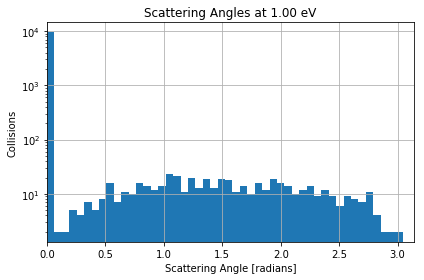

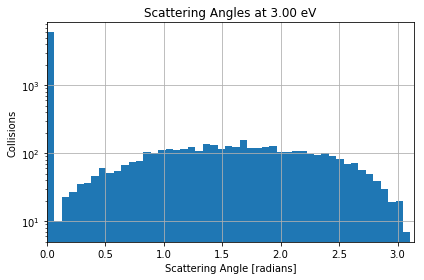

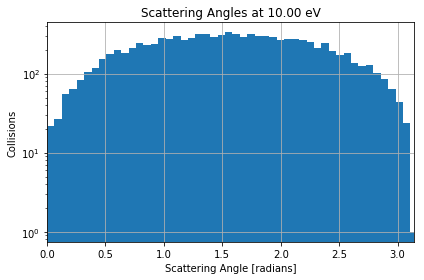

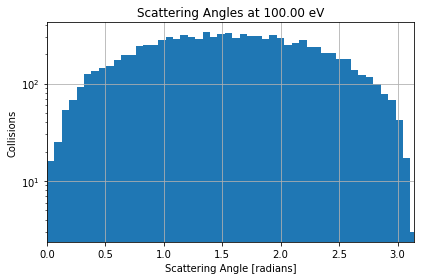

In [4]:
v_vals = np.array([1, 3, 10, 100]) # Starting electron energies
v_vecs = [rand_unit_vec() * k for k in eV_to_v(v_vals)]

steps = 10000 # Number of collisions to simulate

for i, v in enumerate(v_vecs):
    angles = []
    vm_vals = maxwell.rvs(size=steps, scale=a_ar)
    vm_vecs = [rand_unit_vec() * vm_vals[k] for k in range(len(vm_vals))]
    
    for vm in vm_vecs:
        angles.append(v1_ang(v, vm))
        
    # plt.rcParams['font.size'] = 14
    # plt.rcParams['font.family'] = 'serif'
    # fig = plt.figure(figsize=(6, 6))
    
    plt.hist(angles, histtype='stepfilled', bins=np.linspace(0, 2*math.pi, 100))
    
    plt.yscale('log')
    
    plt.xlim(0, math.pi)
    
    plt.title(f'Scattering Angles at {v_vals[i]:.2f} eV')
    plt.xlabel('Scattering Angle [radians]')
    plt.ylabel('Collisions')
    
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # plt.savefig(f'scattering_angle_{v_vals[i]}.pdf', bbox_inches='tight')